<a href="https://colab.research.google.com/github/csy99/dna-nn-theory/blob/master/supervised_viridae(mdl)_sgd256_save_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
import re
import time
import tensorflow as tf
from tensorflow import keras

# Read Data

In [2]:
!pip install PyDrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
data_path = '/content/gdrive/My Drive/Colab Notebooks/viridae/'
records_df = pd.read_csv(data_path + 'reduced_viridae.csv')
# replace all '-' with N (stands for any nt)
records_df.seq = records_df.seq.str.replace('-', 'N')
records_df.head()

,Unnamed: 0,id,seq,label,ngram
0,0,NC_000947.1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,1,"['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NN..."
1,1,NC_001366.1,NNNNNNNNNNTTGAAAGGGGGCCCGGGGGNNNNNNNNNNNNNNNAC...,0,"['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NN..."
2,2,NC_001430.1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0,"['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NN..."
3,3,NC_001445.1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,1,"['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NN..."
4,4,NC_001472.1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0,"['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NN..."


In [4]:
seq_num = 0
for seq in records_df["seq"]:
  char_num = 0
  for char in seq:
    if char != 'A' and char != 'C' and char != 'T' and char != 'G' and char != 'N':
      print("seq", seq_num, 'char', char_num, 'is', char)
    char_num += 1
  seq_num += 1

seq 50 char 973 is Y
seq 182 char 1399 is R
seq 264 char 2084 is R
seq 264 char 2327 is R


In [5]:
records_df.seq = records_df.seq.str.replace('R', 'N')
records_df.seq = records_df.seq.str.replace('Y', 'N')

In [6]:
seq_len = len(records_df.seq[0])
print("The length of the sequence is", seq_len)

The length of the sequence is 2449


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
xtrain_full, xtest, ytrain_full, ytest = train_test_split(records_df, records_df.label, test_size=0.2, random_state=100, stratify=records_df.label)
xtrain, xval, ytrain, yval = train_test_split(xtrain_full, ytrain_full, test_size=0.2, random_state=100, stratify=ytrain_full)
print("shape of training, validation, test set\n", xtrain.shape, xval.shape, xtest.shape, ytrain.shape, yval.shape, ytest.shape)

shape of training, validation, test set
 (179, 5) (45, 5) (57, 5) (179,) (45,) (57,)


In [8]:
word_size = 1
vocab = [''.join(p) for p in product('ACGTN', repeat=word_size)]
# word_to_idx = {word: i for i, word in enumerate(vocab)}
vocab_size = 5
print('vocab_size:', vocab_size)
# print("word_to_idx", word_to_idx)
create1gram = keras.layers.experimental.preprocessing.TextVectorization(
  standardize=lambda x: tf.strings.regex_replace(x, '(.)', '\\1 '), ngrams=1
)
create1gram.adapt(vocab)

vocab_size: 5


In [9]:
def ds_preprocess(x, y):
  x_index = tf.subtract(create1gram(x), 2)
  return x_index, y

In [ ]:
create1gram('A C G T N') - 2

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([4, 3, 2, 0, 1])>

In [10]:
BATCH_SIZE = 256
xtrain_ds = tf.data.Dataset.from_tensor_slices((xtrain['seq'], ytrain)).map(ds_preprocess).batch(BATCH_SIZE)
xval_ds = tf.data.Dataset.from_tensor_slices((xval['seq'], yval)).map(ds_preprocess).batch(BATCH_SIZE)
xtest_ds = tf.data.Dataset.from_tensor_slices((xtest['seq'], ytest)).map(ds_preprocess).batch(BATCH_SIZE)

In [11]:
latent_size = 256

model = keras.Sequential([
    keras.Input(shape=(seq_len,)),
    keras.layers.Embedding(seq_len, latent_size),
    keras.layers.LSTM(latent_size, return_sequences=False),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation="relu"),    
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation="relu"),  
    keras.layers.Dropout(0.2), 
    keras.layers.Dense(16, activation="relu"), 
    keras.layers.Dropout(0.2),   
    keras.layers.Dense(1, activation="sigmoid")                               
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2449, 256)         626944    
_________________________________________________________________
lstm (LSTM)                  (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2

In [12]:
model.compile(optimizer=tf.optimizers.SGD(), loss=tf.losses.BinaryCrossentropy(), metrics='accuracy')
es_cb = keras.callbacks.EarlyStopping(patience=400, restore_best_weights=True)
hist = model.fit(xtrain_ds, validation_data=xval_ds, epochs=5000, callbacks=[es_cb])

流式输出内容被截断，只能显示最后 5000 行内容。
1/1 [==============================] - 0s 242ms/step - loss: 0.6808 - accuracy: 0.5978 - val_loss: 0.6714 - val_accuracy: 0.6000
Epoch 1891/5000
1/1 [==============================] - 0s 248ms/step - loss: 0.6731 - accuracy: 0.6089 - val_loss: 0.6713 - val_accuracy: 0.6000
Epoch 1892/5000
1/1 [==============================] - 0s 226ms/step - loss: 0.6731 - accuracy: 0.6313 - val_loss: 0.6713 - val_accuracy: 0.6000
Epoch 1893/5000
1/1 [==============================] - 0s 242ms/step - loss: 0.6740 - accuracy: 0.5978 - val_loss: 0.6713 - val_accuracy: 0.6000
Epoch 1894/5000
1/1 [==============================] - 0s 252ms/step - loss: 0.6748 - accuracy: 0.6257 - val_loss: 0.6713 - val_accuracy: 0.6000
Epoch 1895/5000
1/1 [==============================] - 0s 228ms/step - loss: 0.6720 - accuracy: 0.6257 - val_loss: 0.6713 - val_accuracy: 0.6000
Epoch 1896/5000
1/1 [==============================] - 0s 244ms/step - loss: 0.6759 - accuracy: 0.6201 - val_loss: 0.67

In [13]:

def save_hist():
  filename = data_path + "baseline_viridae(mdl)_sgd256_history.csv"
  hist_df = pd.DataFrame(hist.history) 
  with open(filename, mode='w') as f:
    hist_df.to_csv(f)
save_hist()

In [14]:
model.save('/content/gdrive/My Drive/Colab Notebooks/models/' + "baseline_viridae(mdl)_sgd256.h5")

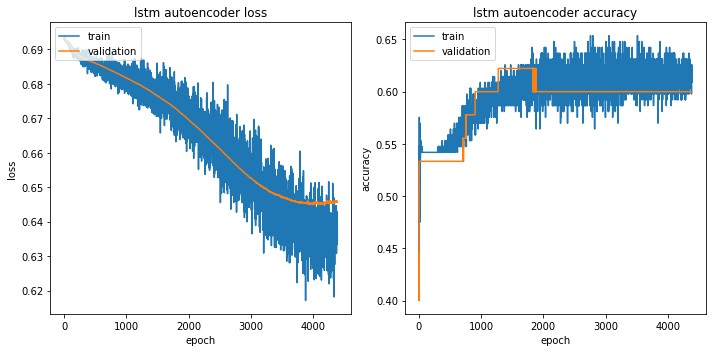

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(1):
  ax1 = axes[0]
  ax2 = axes[1]

  ax1.plot(hist.history['loss'], label='training')
  ax1.plot(hist.history['val_loss'], label='validation')
  ax1.set_title('lstm autoencoder loss')
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss')
  ax1.legend(['train', 'validation'], loc='upper left')
  
  ax2.plot(hist.history['accuracy'], label='training')
  ax2.plot(hist.history['val_accuracy'], label='validation')
  ax2.set_title('lstm autoencoder accuracy')
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('accuracy')
  ax2.legend(['train', 'validation'], loc='upper left')
fig.tight_layout()

In [16]:
def eval_model(model, ds, ds_name="Training"):
  loss, acc = model.evaluate(ds, verbose=0)
  print("{} Dataset: loss = {} and acccuracy = {}%".format(ds_name, np.round(loss, 3), np.round(acc*100, 2)))

In [17]:
eval_model(model, xtrain_ds, "Training")
eval_model(model, xval_ds, "Validation")
eval_model(model, xtest_ds, "Test")

Training Dataset: loss = 0.632 and acccuracy = 62.01%
Validation Dataset: loss = 0.645 and acccuracy = 60.0%
Test Dataset: loss = 0.673 and acccuracy = 59.65%
